In [1]:
import pandas as pd
import os
import sys
import clumpsptm
import pymol
from tqdm import tqdm
import glob
from typing import Union
import matplotlib.pyplot as plt
import numpy as np
import ast

This notebook highlights cohort-specific contribution to CLUMPS-PTM hits.

## 1. Aggregate Result Files
---

In [2]:
results_df = list()

for file in tqdm(glob.glob("clumpsptm_runs/**/*.tsv")):
    _df = pd.read_csv(file, sep='\t', index_col=0)
    _df['id'] = file.split('/')[1]
    results_df.append(_df)
    
results_df = pd.concat(results_df)

100%|██████████| 28/28 [00:02<00:00, 12.98it/s]


In [3]:
# Highlight any hits that are derived from a singular peptide
df = pd.read_csv("ref_uniprot_072522/full_mapped_sites_to_pdbs.tsv", sep='\t', index_col=0)
acc_var_df = df[['accession_number','variableSites']].reset_index().set_index("accession_number").drop_duplicates()

def traceback_peptide3s(row):
    """Traceback peptide 3s"""
    from ast import literal_eval
    
    if row['clumpsptm_input_n'] != 3:
        return None
    else:
        vs3 = {x if len(x.split(" ")) == 3 else None for x in literal_eval(row['variableSites'])}.pop()
        try:
            return acc_var_df[acc_var_df['variableSites']==vs3].loc[row.name]['id']
        except:
            return None

In [4]:
results_df['trace3s'] = results_df.apply(traceback_peptide3s,1).values

## 2. Load Features by Cohort
---

In [250]:
features_df = pd.read_parquet("../../analysis/features_s.parquet")
phosph_features_df = features_df[(features_df["phosphoproteome"].notna()) & (features_df["type"]=="Tumor")]
acetyl_features_df = features_df[(features_df["acetylome"].notna()) & (features_df["type"]=="Tumor")]

_df = results_df[
    (results_df['id']=='dendro_1_positive') &
    (results_df['fdr_corr'] < 0.1) &
    (results_df['clumpsptm_sampler']=='phosphoproteome')
]

_df2 = results_df[
    (results_df['id']=='dendro_1_positive') &
    (results_df['fdr_corr'] < 0.1) &
    (results_df['clumpsptm_sampler']=='acetylome')
]

In [254]:
def filter_by_peptide_source(row, features, feature_type="phosphoproteome"):
    """Filter by peptide source."""
    from ast import literal_eval

    residues = [x+str(y)+x.lower() for x,y in zip(literal_eval(row['acc_res']),literal_eval(row['acc_res_i']))]

    protein_features = features[features[feature_type].str.startswith(row.name)]
    return protein_features[protein_features[feature_type].str.replace(row.name,"").str.contains('|'.join(residues))]

def collapse_peptide_cohort_counts(results_df, features_df, **kwargs):
    """Collapse peptide cohort counts."""
    _rows = list()

    for idx,row in results_df.iterrows():
        _row = filter_by_peptide_source(row, features_df, **kwargs).groupby('cohort').size()
        _row.name = row['y']
        _rows.append(_row)

    return pd.concat(_rows,1).fillna(0).astype(int).T

In [321]:
import seaborn as sns

phosph_counts = collapse_peptide_cohort_counts(_df, phosph_features_df, feature_type="phosphoproteome")
acetyl_counts = collapse_peptide_cohort_counts(_df2, acetyl_features_df, feature_type="acetylome")

/home/sanand/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  


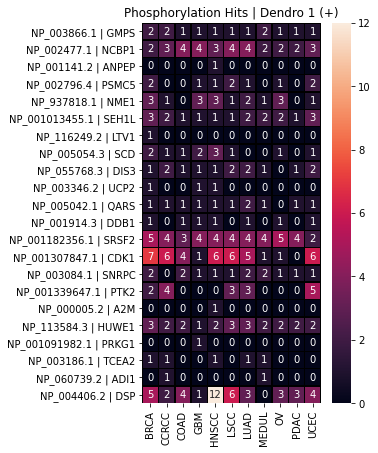

In [273]:
fig, ax = plt.subplots(figsize=(4,7))

sns.heatmap(
    phosph_counts,
    xticklabels=True,
    yticklabels=True,
    ax=ax,
    linewidths=0.5,
    linecolor='black',
    annot=True
    )

ax.set_xlabel("")
ax.set_title("Phosphorylation Hits | Dendro 1 (+)")
plt.savefig("reviewer_cohort_clumpsptm_a.pdf", dpi=300, bbox_inches='tight')

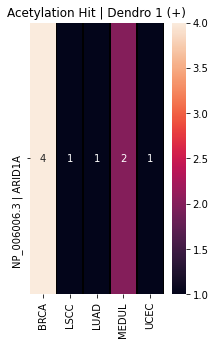

In [274]:
fig, ax = plt.subplots(figsize=(3,5))

sns.heatmap(
    acetyl_counts,
    xticklabels=True,
    yticklabels=True,
    ax=ax,
    linewidths=0.5,
    linecolor='black',
    annot=True
    )

ax.set_xlabel("")
ax.set_title("Acetylation Hit | Dendro 1 (+)")
plt.savefig("reviewer_cohort_clumpsptm_b.pdf", dpi=300, bbox_inches='tight')

## 3. Aggregate Data
---

In [13]:
phosph_df = pd.read_csv("../../data/processed/061721/raw/phosphoproteome_X.tsv.gz", sep='\t', index_col=0)
acetyl_df = pd.read_csv("../../data/processed/061721/raw/acetylome_X.tsv.gz", sep='\t', index_col=0)

In [43]:
samples_df = pd.read_csv("../../analysis/signatures/061721_imputed_res_reg/mappings_pancan_102322.tsv", sep="\t", index_col=0).join(
    #pd.read_csv("../../analysis/dendro_lr_df_021422.tsv", sep="\t", index_col=0)[['1','2']]
    pd.read_csv("../../analysis/diffexp/061721_imputed_res_reg_dendro/mappings.tsv", sep="\t", index_col=0)[['1','2']]
)

In [73]:
phosph_df = phosph_df.loc[:,samples_df.index]
acetyl_df = acetyl_df.loc[:,np.intersect1d(acetyl_df.columns, samples_df.index)]

In [77]:
row = results_df[(results_df['clumpsptm_sampler']=='phosphoproteome') & (results_df['geneSymbol']=='SRSF2')].iloc[2]

In [325]:
def compute_feature_by_cohort_lfc(
    row,
    data,
    features_df,
    samples_df,
    param='1',
    feature_type='phosphoproteome'
    ):
    # Subset phosphoproteome peptide inputs to row
    row_feat_df = data.loc[set(filter_by_peptide_source(row, features_df, feature_type=feature_type)[feature_type])]

    # Set Split side to negatives
    row_feat_df.loc[:,samples_df[~samples_df[param]].index] = row_feat_df.loc[:,samples_df[~samples_df[param]].index] * -1

    # Get logFC
    row_feat_df = row_feat_df.T.join(samples_df[['cohort', param]]).groupby(['cohort',param]).mean().groupby(level=[0]).sum().T

    # Res Id
    row_feat_df['resid'] = [int(x.split("_")[-2]) for x in row_feat_df.index]
    row_feat_df = row_feat_df.sort_values('resid')
    row_feat_df = row_feat_df.drop(columns=['resid'])
    row_feat_df.index = ['|'.join(x.split("_")[2:]) for x in row_feat_df.index]
    
    return row_feat_df

/home/sanand/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  


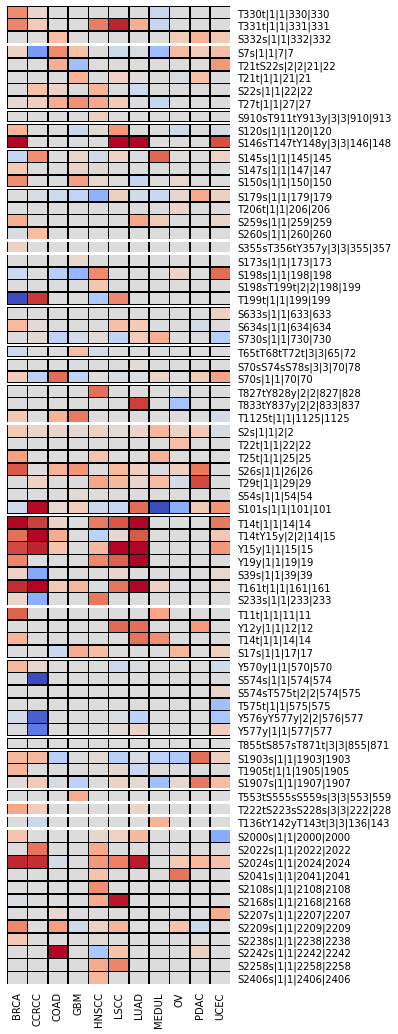

In [305]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize =([4, 24]))
 
gs = gridspec.GridSpec(100,1)

i=0
j=0
for idx,row in _df.iterrows():
    row_feat_df = compute_feature_by_cohort_lfc(row, phosph_df, phosph_features_df, samples_df)
    
    ax = plt.subplot(gs[j:j+row_feat_df.shape[0],:])
    
    sns.heatmap(
        row_feat_df,
        cmap='coolwarm',
        vmin=-1.5,
        vmax=1.5,
        xticklabels=True,
        yticklabels=True,
        ax=ax,
        linewidths=0.5,
        linecolor='black',
        cbar=False
    )
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    ax.set_xlabel(None)
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.tick_right()
    ax.yaxis.set_ticks_position('none')
    
    if i != 21:
        ax.set_xticklabels([])
    
    i+=1
    j = j + row_feat_df.shape[0]
    
plt.savefig("reviewer_cohort_clumpsptm_c.pdf", dpi=300, bbox_inches='tight')

In [326]:
row_feat_df = compute_feature_by_cohort_lfc(
    _df2.iloc[0], 
    acetyl_df, 
    acetyl_features_df, 
    samples_df.loc[acetyl_df.columns], 
    feature_type='acetylome'
)

/home/sanand/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  


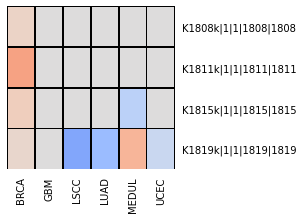

In [347]:
fig,ax = plt.subplots(figsize=(3,3))

sns.heatmap(
    row_feat_df,
    cmap='coolwarm',
    vmin=-1.5,
    vmax=1.5,
    xticklabels=True,
    yticklabels=True,
    ax=ax,
    linewidths=0.5,
    linecolor='black',
    cbar=False
)

ax.set_xlabel(None)
ax.xaxis.set_ticks_position('none')
ax.yaxis.tick_right()
ax.yaxis.set_ticks_position('none')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.savefig("reviewer_cohort_clumpsptm_d.pdf", dpi=300, bbox_inches='tight')